# Demo: NAS with graph morphisms

In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import time
from torchviz import make_dot
import os

In [2]:
print("pytorch",torch.__version__)
print("cuda", torch.version.cuda)
print("cudnn", torch.backends.cudnn.version())
torch.cuda.is_available()


pytorch 1.3.1
cuda 10.0.130
cudnn 7605


True

## Set_up parameters and train/test functions

The train set is randomly split into a true training set, which will be used to train candidate models, and a cross-validation set that will be used to evaluate their accuracy and select the best model as a father of the next generation.

In [26]:
INPUT_SIZE = 32
INPUT_CHN = 3

N_CLASS = 10
N_EPOCH_TRAIN = 4

BATCH_SIZE = 100
LEARNING_RATE = 1e-4

CIFAR_NAMES = ("airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck")

In [4]:
class Cutout(object):
    def __init__(self,patch_size=16,channel_proba=1.0, default_values = [.5,.5,.5]):
        self.patch_size=patch_size
        self.channel_proba = channel_proba
        self.default_values = default_values
    def __call__(self,img):
        npimg = np.array(img)
        h,w,c = npimg.shape
        w1 = np.random.choice(w+self.patch_size-1) - self.patch_size + 1
        w2 = w1 + self.patch_size
        w1 = np.maximum(w1,0)
        w2 = np.minimum(w2,w)

        h1 = np.random.choice(h+self.patch_size-1) - self.patch_size + 1
        h2 = h1 + self.patch_size
        h1 = np.maximum(h1,0)
        h2 = np.minimum(h2,h)

        for channel,val in enumerate(self.default_values):
            if np.random.rand()<=self.channel_proba :
                npimg[h1:h2, w1:w2, channel]=val        

        img = transforms.functional.to_pil_image(npimg)
        return img

In [5]:
# Data Loader (Input Pipeline)
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    Cutout(patch_size=16, default_values=[127., 124., 115.]),
    transforms.ToTensor()])

# CIFAR Dataset
train_dataset = datasets.CIFAR10(
    root='./cifar_data/', train=True, transform=train_transforms, download=True)
test_dataset = datasets.CIFAR10(
    root='./cifar_data/', train=False, transform=transforms.ToTensor(), download=False)
train_small_set, crossval_set = torch.utils.data.random_split(train_dataset, [
                                                              40000, 10000])

loader_args = {"batch_size": BATCH_SIZE, "pin_memory": True}
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, shuffle=True, **loader_args)
train_small_loader = torch.utils.data.DataLoader(
    dataset=train_small_set, shuffle=True, **loader_args)

cv_loader = torch.utils.data.DataLoader(
    dataset=crossval_set, shuffle=False, **loader_args)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, shuffle=False, **loader_args)

Files already downloaded and verified


In [6]:
def train_net(net, optimizer, n_epoch=10, criterion=F.cross_entropy, display_interval=100,
             verbose=3, dataset="small"):
    net.train(True)
    if dataset == "full":
        dataloader = train_loader
    elif dataset == "small":
        dataloader = train_small_loader
    else:
        raise(ValueError("dataset argument: expected 'full' or 'small'"))
        
    print("Training on %s set..."%dataset)
    t0 = time.time()
    t00 = t0
    optimizer.zero_grad()

    for epoch in range(n_epoch):
        cumul_loss = 0.0
        running_loss = 0.0
        for batch_idx, (X, y) in enumerate(dataloader):
            X = X.cuda()
            y = y.cuda()

            y_pred = net(X)

            loss = criterion(y_pred, y)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            running_loss += loss.item()
            cumul_loss += loss.item()

            batch_idx += 1
            if batch_idx % display_interval == 0:
                running_loss /= display_interval
                t1 = time.time()
                if verbose >=3:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}\tt={:.1f}s'.format(
                        epoch, batch_idx * len(X), len(dataloader.dataset),
                        100. * batch_idx / len(dataloader), running_loss, t1-t0))
                running_loss = 0

        cumul_loss /= batch_idx
        t1 = time.time()
        if verbose>=2:
            print('====> Epoch: {} done in {:.1f}s, Average loss: {:.4f}'.format(
                epoch, t1-t0, cumul_loss))
        t0 = t1
    if verbose>=1:
        print('Training done, {} epochs in {:.1f}s, loss at last epoch: {:.4f}'.format(
            n_epoch, t1-t00, cumul_loss))

In [7]:
def test_net(net, dataset="test", criterion=F.cross_entropy, proba_extractor = lambda x:x):
    net.eval()

    if dataset=="train":
        print("Evaluate net on TRAIN:")
        dataloader = train_loader
    elif dataset=="cv":
        print("Evaluate net on CROSSVAL:")
        dataloader = cv_loader
    elif dataset=="test":
        print("Evaluate net on TEST:")
        dataloader = test_loader
    else:
        raise(ValueError("dataset argument: expected 'train', 'cv' or 'test'"))
    n_in_dataset = len(dataloader.dataset)
    
    cumul_loss = 0.0
    class_ok = 0
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(dataloader):
            X = X.cuda()
            ground_truth = y.numpy()
            y = y.cuda()

            net_output = net(X)
            cumul_loss += criterion(net_output, y).item()
            
            y_soft = proba_extractor(net_output)
            _, y_hard = y_soft.max(1)

            prediction = y_hard.cpu().numpy()
            class_ok += np.sum(ground_truth == prediction)

    cumul_loss /= batch_idx+1
    accuracy = class_ok / n_in_dataset
    print("Well classified %5d / %5d, (%5.2f%% accuracy)" % (
        class_ok, n_in_dataset, 100*accuracy))
    print("Average loss : %f" % cumul_loss)
    return cumul_loss, accuracy

## Sample test
Just train a simple network to check that `train_net` and `test_net` work as expected, and get a baseline for what level of accuracy can be expected. First, images from the augmented train set are displayed.

In [8]:
image = np.zeros(( (32+2)*10-2, (32+2)*10-2, 3))
img_labels=[]
for ii in range(10):
    for jj in range(10):
        a = ii*(32+2)
        b = jj*(32+2)
        data=train_dataset[jj+10*ii]
        image[a:a+32, b:b+32,:] = np.transpose(data[0].numpy(),(1,2,0))
        img_labels.append((a,b,CIFAR_NAMES[data[1]]))


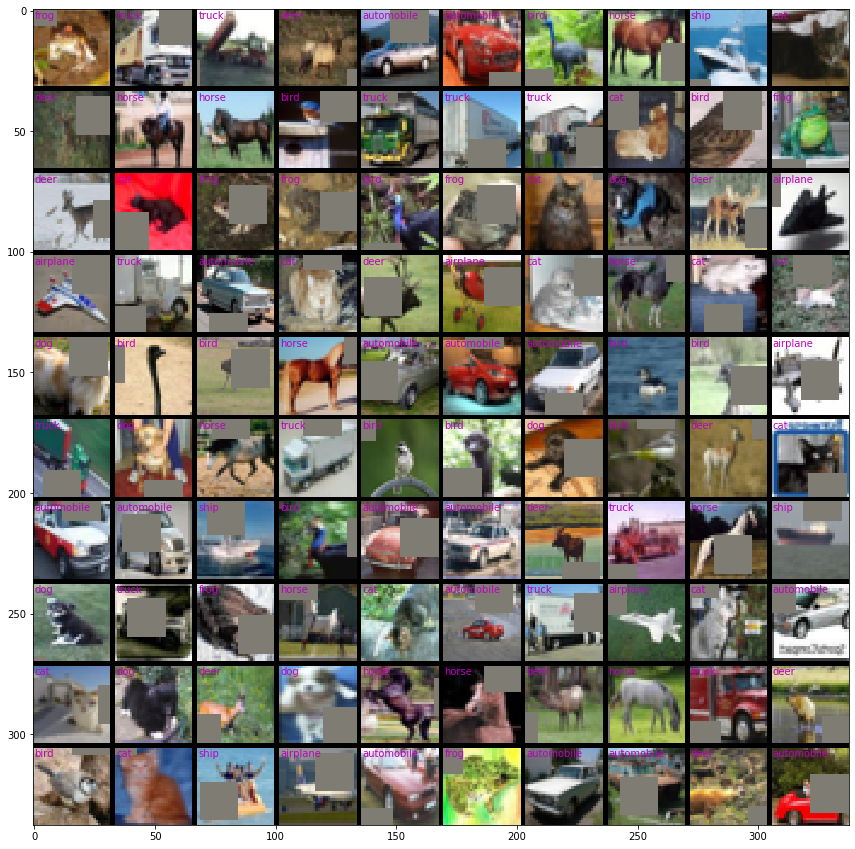

In [9]:
plt.figure(figsize=(15,15))
plt.imshow(image);
for a,b,img_label in img_labels:
    plt.text(b,a,img_label,color='m',va="top")

In [10]:
net01 = nn.Sequential(nn.BatchNorm2d(3),
                    nn.Conv2d(3, 64, (5, 5), bias=True, padding=2, padding_mode='replicate'),
                    nn.ReLU(),
                    nn.Conv2d(64, 64, (5, 5), bias=True, padding=2, padding_mode='replicate'),
                    nn.ReLU(),
                    nn.MaxPool2d(2, stride=2),
                    # Downsample to 16x16
                    nn.BatchNorm2d(64), 
                    nn.Conv2d(64, 128, (3, 3), bias=True, padding=1,
                              padding_mode='replicate'),
                    nn.ReLU(),
                    nn.Conv2d(128, 128, (3, 3), bias=True, padding=1,
                              padding_mode='replicate'),
                    nn.ReLU(),
                    nn.MaxPool2d(2, stride=2),
                    # Downsample to 8x8
                    nn.BatchNorm2d(128), 
                    nn.Conv2d(128, 256, (3, 3), bias=True, padding=1,
                              padding_mode='replicate'),
                    nn.ReLU(),
                    nn.Conv2d(256, 256, (3, 3), bias=True, padding=1,
                              padding_mode='replicate'),
                    nn.ReLU(),
                    nn.MaxPool2d(2, stride=2),                    
                    # Downsample to 4x4
                    nn.BatchNorm2d(256),
                    nn.Conv2d(256, 512, (3, 3), bias=True, padding=1,
                    padding_mode='replicate'),                    
                    # Classifier  
                    nn.Flatten(),
                    nn.Linear(512*4*4, 2048),
                    nn.ReLU(),
                    nn.Linear(2048, 10),
                    nn.Softmax(dim=1))
net01.cuda()
optimizer = optim.Adam(net01.parameters(), lr=LEARNING_RATE)

In [12]:
train_net(net01,optimizer, n_epoch=15, dataset="full")

Training on full set...
Train Epoch: 0 [10000/50000 (20%)]	Loss: 2.1141	t=12.5s
Train Epoch: 0 [20000/50000 (40%)]	Loss: 2.0335	t=25.3s
Train Epoch: 0 [30000/50000 (60%)]	Loss: 2.0006	t=37.6s
Train Epoch: 0 [40000/50000 (80%)]	Loss: 1.9831	t=50.1s
Train Epoch: 0 [50000/50000 (100%)]	Loss: 1.9639	t=62.1s
====> Epoch: 0 done in 62.1s, Average loss: 2.0190
Train Epoch: 1 [10000/50000 (20%)]	Loss: 1.9281	t=12.5s
Train Epoch: 1 [20000/50000 (40%)]	Loss: 1.9206	t=24.6s
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.9080	t=36.5s
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.9008	t=48.5s
Train Epoch: 1 [50000/50000 (100%)]	Loss: 1.9045	t=60.6s
====> Epoch: 1 done in 60.6s, Average loss: 1.9124
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.8745	t=12.0s
Train Epoch: 2 [20000/50000 (40%)]	Loss: 1.8894	t=24.3s
Train Epoch: 2 [30000/50000 (60%)]	Loss: 1.8804	t=36.9s
Train Epoch: 2 [40000/50000 (80%)]	Loss: 1.8696	t=49.7s
Train Epoch: 2 [50000/50000 (100%)]	Loss: 1.8604	t=62.1s
====> Epoch: 2 done in 62.1s, A

In [13]:
test_net(net01, dataset="train")
test_net(net01, dataset="test")

Evaluate net on TRAIN:
Well classified 36567 / 50000, (73.13% accuracy)
Average loss : 1.728762
Evaluate net on TEST:
Well classified  7315 / 10000, (73.15% accuracy)
Average loss : 1.728283


(1.7282834160327911, 0.7315)

## Morphism turner
This is done with a variant of NNI Morphism tuner toolbox, which already almost contains everything needed.

It implements a class to represent a Neural Network as a graph and function-preserving morphisms to alter the graph without altering the classification results.

The Bayesian optimizer is replaced by a simple hill climbing algorithm (as in [Elsken 2017](https://arxiv.org/pdf/1711.04528.pdf)) where the most accurate model on test set is repeatedely evolved into a generation of candidates that are trained for a few epochs (giving at each generation a new best candidate).

NNI toolbox natively saves only the model architectures without the weights. This defeats the purpose of *graph morphisms*, which is to speed-up training by re-using the weights. The `graph` and `graph_transform` packages of the toolbox, however, contain everything needed to morph graphs with weights properly handled. Some methods of the tuner are overloaded to allow network weights to be saved as a *.torch* file that goes along with the *json* file that describes the architecture.

**Caveat:** The code below uses the CIFAR10 train dataset augmented with cutout and random horizontal flips, split into a train and a crossvalidation set, to train and evaluate the neural networks. Evaluation thus is done on images with patches blanked (Cutout) rather than full images. This explains why the models perform better on the CIFAR test set (never seen at any point during the architecture search) than on the cross-validation set.

In [14]:
from nni.networkmorphism_tuner.networkmorphism_tuner import NetworkMorphismTuner
from nni.networkmorphism_tuner.graph import graph_to_json, json_to_graph


In [15]:
from copy import deepcopy

from nni.utils import OptimizeMode
from nni.networkmorphism_tuner.graph_transformer import transform
from nni.networkmorphism_tuner.utils import Constant
from nni.networkmorphism_tuner.bayesian import SearchTree, edit_distance, contain
from nni.networkmorphism_tuner.networkmorphism_tuner import NetworkMorphismTuner


class HillClimbingOptimizer:
    """ A Bayesian optimizer for neural architectures.
    Attributes:
        gen_size
    """

    def __init__(self, tuner, gen_size=8):
        Constant.N_NEIGHBOURS = gen_size*2
        self.gen_size = gen_size
        self.searcher = tuner
        self.search_tree = SearchTree()
        self.generation_queue = []

    def fit(self, x_queue, y_queue):
        pass

    def generate(self, descriptors):
        """Generate new architecture.
        Args:
            descriptors: All the searched neural architectures.
        Returns:
            graph: An instance of Graph. A morphed neural network with weights.
            father_id: The father node ID in the search tree.
        """
        new_queue = []
        for _ in range(3):
            if new_queue:
                break

            father_id = self.searcher.get_best_model_id()
            graph = self.searcher.load_model_by_id(father_id, load_weights=True)
                
            for temp_graph in transform(graph):
                if contain(descriptors, temp_graph.extract_descriptor()):
                    continue
                descriptors.append(temp_graph.extract_descriptor())
                new_queue.append(temp_graph)
            new_queue = new_queue[:self.gen_size]
            
        if not new_queue:
            return None, None
        else:
            return new_queue, father_id

    def add_child(self, father_id, model_id):
        ''' add child to the search tree
        Arguments:
            father_id {int} -- father id
            model_id {int} -- model id
        '''

        self.search_tree.add_child(father_id, model_id)


class HillClimbingTuner(NetworkMorphismTuner):
    '''Overwrite the Bayesian optimizer in NetworkMorphismTuner
       with the Hill Climbing algorithm
    '''
    def __init__(self, **kwargs):
        gen_size = kwargs.pop("gen_size", 8)
        super(HillClimbingTuner, self).__init__(**kwargs)
        self.bo = HillClimbingOptimizer(self, gen_size)
        
    def generate_parameters(self, parameter_id, **kwargs):
        """
        Returns a set of trial neural architecture, as a serializable object.
        Parameters
        ----------
        parameter_id : int
        """
        if not self.history:
            self.init_search()

        new_father_id = None
        generated_graph = None
        if not self.training_queue:
            new_father_id, graph_list = self.generate()
            if type(graph_list) is not list:
                graph_list = [graph_list]
            for generated_graph in graph_list:
                new_model_id = self.model_count
                self.model_count += 1
                self.training_queue.append(
                    (generated_graph, new_father_id, new_model_id))
                self.descriptors.append(generated_graph.extract_descriptor())

        graph, father_id, model_id = self.training_queue.pop(0)

        # from graph to json
        json_out = self.save_weighted_graph(graph, model_id)
        self.total_data[parameter_id] = (json_out, father_id, model_id)

        return graph

    def load_model_by_id(self,father_id, load_weights=False):
        """Overload to work with weights"""
        graph = super(HillClimbingTuner,self).load_model_by_id(father_id)

        if load_weights and graph.weighted:
            weight_path = os.path.join(self.path, str(father_id) + ".torch")
            state_dict = torch.load(weight_path)
            model = graph.produce_torch_model()
            model.load_state_dict(state_dict)
            model.set_weight_to_graph()
            graph = model.graph
        return graph
    
    def update_from_model(self,model,parameter_id):
        _, father_id, model_id = self.total_data[parameter_id]
        json_out = self.save_weighted_graph(model.graph, model_id)
        self.total_data[parameter_id] = (json_out, father_id, model_id)

    def save_weighted_graph(self,graph, model_id):
        json_model_path = os.path.join(self.path, str(model_id) + ".json")
        json_out = graph_to_json(graph, json_model_path)
        if graph.weighted:
            weight_path = os.path.join(self.path, str(father_id) + ".torch")
            model = graph.produce_torch_model()
            state_dict = model.state_dict()
            torch.save(state_dict,weight_path)
        return json_out
    
    def receive_trial_result(self, parameter_id, value, model=None, **kwargs):
        if model is not None:
            self.update_from_model(model,parameter_id)
        super(HillClimbingTuner,self).receive_trial_result(parameter_id, None, value, **kwargs)

Use the tuner to minimise the loss function (maximizing accuracy is another option)

In [30]:
tuner = HillClimbingTuner(
    task = "cv",
    input_width = INPUT_SIZE,
    input_channel = INPUT_CHN,
    n_output_node = N_CLASS,
    optimize_mode = "minimize",
    path = "test_cifar_cv",
    gen_size = 8)

In [31]:
model_nb = 0
gen_id = 0
n_iter = 0
timing=[]
losses=[]
accuracies=[]
parameters=[]

if os.path.isdir(tuner.path):
    filesToRemove = [os.path.join(tuner.path,f) for f in os.listdir(tuner.path)]
    for f in filesToRemove:
        os.remove(f) 

In [32]:
t00 = time.time()
t0 = t00
while gen_id <= 8 and n_iter < 80:
    print("\n=========================")
    parameter_id = "gen%02d_model%d"%(gen_id,model_nb)
    print("Iteration %d - %s - %ds elapsed"%(n_iter,parameter_id, t0-t00))
    
    graph = tuner.generate_parameters(parameter_id)
    model = graph.produce_torch_model().cuda()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    train_net(model, optimizer, n_epoch=N_EPOCH_TRAIN, verbose=1, dataset="small")
    loss, accuracy = test_net(model, dataset="cv")
    loss_t, accuracy_t = test_net(model, dataset="test")
    model.cpu()
    
    tuner.receive_trial_result(parameter_id, loss, model)  
        
    parameters.append(parameter_id)
    print("Best model so far : %s (%d)"%(parameters[tuner.get_best_model_id()],tuner.get_best_model_id()))
    
    n_iter += 1
    if tuner.training_queue: 
        model_nb += 1
    else:
        gen_id += 1
        model_nb = 0
    
    
    t1=time.time()
    timing.append(t1-t0)
    t0=t1
    losses.append([loss,loss_t])
    accuracies.append([accuracy,accuracy_t])
tt = t1-t00
h = (tt)//3600
m = (tt - 3600*h)//60
s = (tt - 3600*h - 60*m)//1
print("******** DONE ********")
print("Full NAS search done in %dh %dm %ds seconds"%(h,m,s))

accuracies = np.array(accuracies)
losses = np.array(losses)
timing = np.array(timing)

arr_path = os.path.join(tuner.path, "metrics.npz")
np.savez(arr_path, timing=timing,
        losses=losses, accuracies=accuracies)


Iteration 0 - gen00_model0 - 0s elapsed
Training on small set...
Training done, 4 epochs in 53.2s, loss at last epoch: 1.4218
Evaluate net on CROSSVAL:
Well classified  5055 / 10000, (50.55% accuracy)
Average loss : 1.365091
Evaluate net on TEST:
Well classified  5138 / 10000, (51.38% accuracy)
Average loss : 1.312501
Best model so far : gen00_model0 (0)

Iteration 1 - gen01_model0 - 57s elapsed
Training on small set...
Training done, 4 epochs in 56.1s, loss at last epoch: 1.4022
Evaluate net on CROSSVAL:
Well classified  5108 / 10000, (51.08% accuracy)
Average loss : 1.360894
Evaluate net on TEST:
Well classified  5284 / 10000, (52.84% accuracy)
Average loss : 1.304723
Best model so far : gen01_model0 (1)

Iteration 2 - gen01_model1 - 117s elapsed
Training on small set...
Training done, 4 epochs in 62.0s, loss at last epoch: 1.4138
Evaluate net on CROSSVAL:
Well classified  5093 / 10000, (50.93% accuracy)
Average loss : 1.359611
Evaluate net on TEST:
Well classified  5252 / 10000, (5

Training done, 4 epochs in 77.4s, loss at last epoch: 1.2517
Evaluate net on CROSSVAL:
Well classified  5776 / 10000, (57.76% accuracy)
Average loss : 1.189984
Evaluate net on TEST:
Well classified  5952 / 10000, (59.52% accuracy)
Average loss : 1.135026
Best model so far : gen03_model4 (21)

Iteration 22 - gen03_model5 - 1650s elapsed
Training on small set...
Training done, 4 epochs in 78.1s, loss at last epoch: 1.3311
Evaluate net on CROSSVAL:
Well classified  5458 / 10000, (54.58% accuracy)
Average loss : 1.270294
Evaluate net on TEST:
Well classified  5666 / 10000, (56.66% accuracy)
Average loss : 1.204210
Best model so far : gen03_model4 (21)

Iteration 23 - gen03_model6 - 1734s elapsed
Training on small set...
Training done, 4 epochs in 78.6s, loss at last epoch: 1.3188
Evaluate net on CROSSVAL:
Well classified  5533 / 10000, (55.33% accuracy)
Average loss : 1.254721
Evaluate net on TEST:
Well classified  5678 / 10000, (56.78% accuracy)
Average loss : 1.192668
Best model so far :

Well classified  6221 / 10000, (62.21% accuracy)
Average loss : 1.070687
Evaluate net on TEST:
Well classified  6422 / 10000, (64.22% accuracy)
Average loss : 1.011766
Best model so far : gen06_model0 (41)

Iteration 43 - gen06_model2 - 4240s elapsed
Training on small set...
Training done, 4 epochs in 143.8s, loss at last epoch: 1.0731
Evaluate net on CROSSVAL:
Well classified  6375 / 10000, (63.75% accuracy)
Average loss : 1.054107
Evaluate net on TEST:
Well classified  6452 / 10000, (64.52% accuracy)
Average loss : 0.993963
Best model so far : gen06_model0 (41)

Iteration 44 - gen06_model3 - 4393s elapsed
Training on small set...
Training done, 4 epochs in 150.1s, loss at last epoch: 1.0611
Evaluate net on CROSSVAL:
Well classified  6521 / 10000, (65.21% accuracy)
Average loss : 1.001578
Evaluate net on TEST:
Well classified  6636 / 10000, (66.36% accuracy)
Average loss : 0.951831
Best model so far : gen06_model0 (41)

Iteration 45 - gen06_model4 - 4552s elapsed
Training on small set

Well classified  7179 / 10000, (71.79% accuracy)
Average loss : 0.797903
Best model so far : gen08_model5 (62)

Iteration 64 - gen08_model7 - 9726s elapsed
Training on small set...
Training done, 4 epochs in 310.7s, loss at last epoch: 0.9049
Evaluate net on CROSSVAL:
Well classified  6861 / 10000, (68.61% accuracy)
Average loss : 0.895498
Evaluate net on TEST:
Well classified  7075 / 10000, (70.75% accuracy)
Average loss : 0.810307
Best model so far : gen08_model5 (62)
******** DONE ********
Full NAS search done in 2h 47m 39s seconds


Text(0.5, 0, 'Model ID')

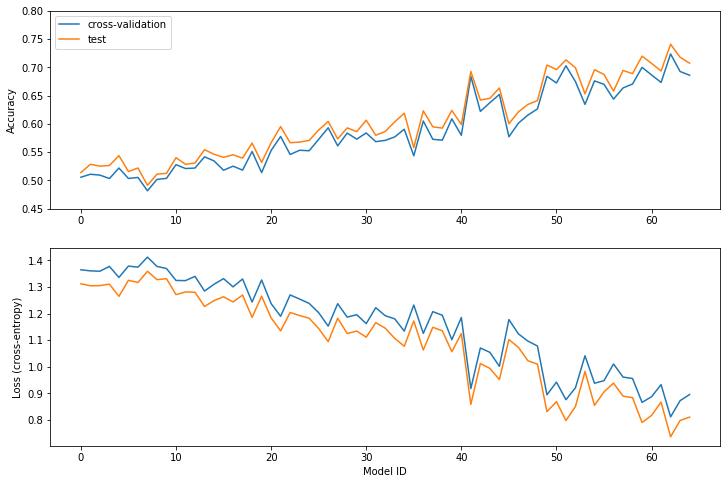

In [38]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(accuracies[:,0],label="cross-validation")
plt.plot(accuracies[:,1],label="test")
plt.ylabel("Accuracy")
plt.ylim(.45,.8)
plt.legend()

plt.subplot(2,1,2)
plt.plot(losses[:,0], label="crossval");
plt.plot(losses[:,1], label="test");
plt.ylabel("Loss (cross-entropy)")
plt.xlabel("Model ID")

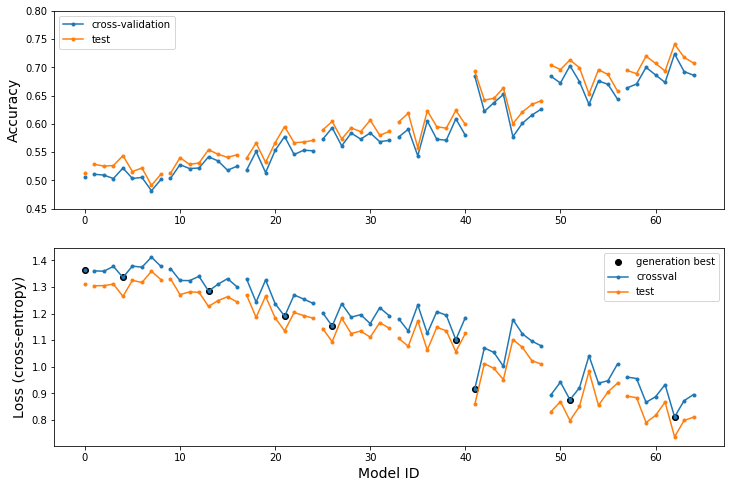

In [65]:
def insert_gap(vec, gen_size=8):
    """Inser a nan in the vector between generations"""
    n_models = vec.size
    model_id = np.arange(vec.size)
    gen = 1 + (model_id-1)//gen_size
    last_gen = gen[-1]

    ind = np.empty((n_models+last_gen,))
    ind[:] = np.nan
    val = np.empty((n_models+last_gen,))
    val[:] = np.nan

    ind[model_id+gen] = model_id
    val[model_id+gen] = vec
    return ind, val


def get_best_metric(vec, gen_size=8):
    """Return id and metric of best model at each generation"""
    n_models = vec.size
    model_id = np.arange(vec.size)
    gen = 1 + (model_id-1)//gen_size
    n_gen = gen[-1]+1
    best_id, best_metric = np.zeros((n_gen)), np.zeros((n_gen))
    for ii in range(n_gen):
        imin = vec[gen == ii].argmin()
        shift = 0 if 0 == ii else 1+(ii-1)*gen_size
        best_id[ii] = imin+shift
        best_metric[ii] = vec[imin+shift]
    return best_id, best_metric


plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(*insert_gap(accuracies[:, 0]), ".-", label="cross-validation")
plt.plot(*insert_gap(accuracies[:, 1]), ".-",label="test")
plt.ylim(.45, .8)
plt.legend()
plt.ylabel("Accuracy", fontsize=14)

plt.subplot(2, 1, 2)
plt.plot(*get_best_metric(losses[:, 0]), "ok", label="generation best")
plt.plot(*insert_gap(losses[:, 0]), ".-",label="crossval")
plt.plot(*insert_gap(losses[:, 1]), ".-",label="test")
plt.ylabel("Loss (cross-entropy)", fontsize=14)
plt.xlabel("Model ID", fontsize=14)
plt.legend();

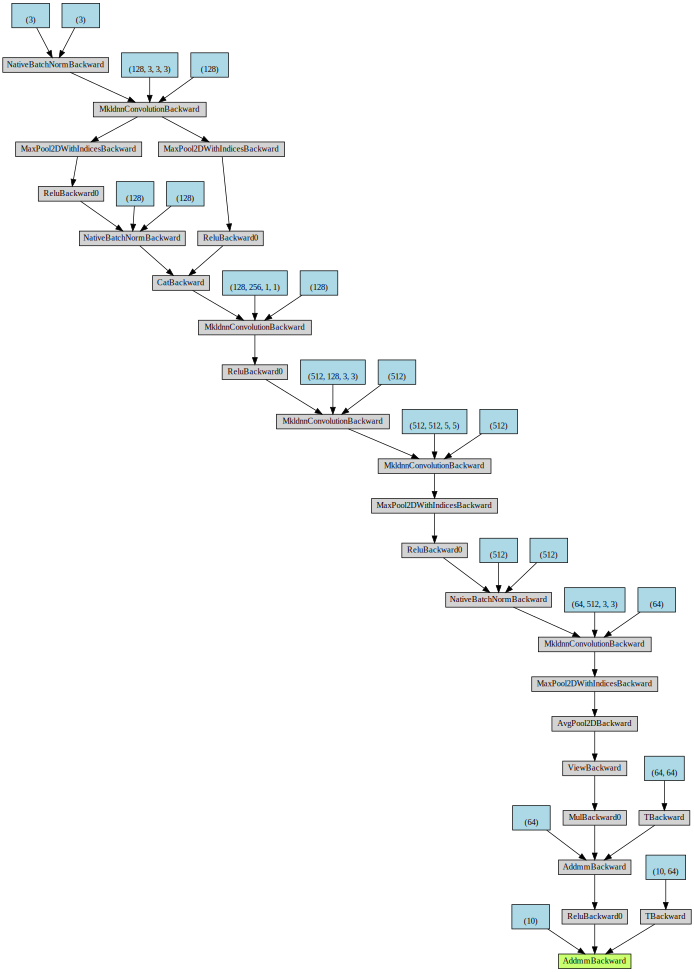

In [36]:
best_graph = tuner.load_best_model()
best_model = best_graph.produce_torch_model()

x,y = test_dataset[0]
x.unsqueeze_(0)
make_dot(best_model(x))